In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)


Project root added: C:\Users\cerva\OneDrive\Desktop\Asset Management Risk Portfolio


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.config import (
    ASSET_UNIVERSE, START_DATE, END_DATE, PRICE_FIELD,
    MIN_COVERAGE, RETURN_KIND,
    RAW_PRICES_PARQUET, PROCESSED_RETURNS_PARQUET
)
from utils.data import ensure_dirs, download_prices, align_and_clean, coverage_filter, compute_returns
from utils.analytics import annualize_return, annualize_vol, max_drawdown_from_returns, correlation_matrix

ensure_dirs(["data/raw", "data/processed"])


In [3]:
tickers = list(ASSET_UNIVERSE.keys())
len(tickers), tickers[:10]


(45, ['SPY', 'QQQ', 'IWM', 'DIA', 'EFA', 'EEM', 'VNQ', 'GLD', 'DBC', 'TLT'])

In [4]:
prices = download_prices(
    tickers=tickers,
    start=START_DATE,
    end=END_DATE,
    field=PRICE_FIELD
)
prices = align_and_clean(prices)

prices.shape, prices.index.min(), prices.index.max()


((3013, 45),
 Timestamp('2014-01-02 00:00:00'),
 Timestamp('2025-12-23 00:00:00'))

In [5]:
prices_filt, coverage = coverage_filter(prices, min_coverage=MIN_COVERAGE)

dropped = [t for t in prices.columns if t not in prices_filt.columns]
print("Kept:", len(prices_filt.columns))
print("Dropped:", len(dropped))
print("Dropped tickers:", dropped)

coverage.head(10), coverage.tail(10)


Kept: 45
Dropped: 0
Dropped tickers: []


(Ticker
 AAPL     1.0
 AGG      1.0
 AMZN     1.0
 BAC      1.0
 BRK-B    1.0
 COST     1.0
 CVX      1.0
 DBC      1.0
 DIA      1.0
 EEM      1.0
 dtype: float64,
 Ticker
 XLB    1.0
 XLE    1.0
 XLF    1.0
 XLI    1.0
 XLK    1.0
 XLP    1.0
 XLU    1.0
 XLV    1.0
 XLY    1.0
 XOM    1.0
 dtype: float64)

In [6]:
rets = compute_returns(prices_filt, kind=RETURN_KIND)

rets.shape, rets.index.min(), rets.index.max()


((3012, 45),
 Timestamp('2014-01-03 00:00:00'),
 Timestamp('2025-12-23 00:00:00'))

In [7]:
summary = []
for t in rets.columns:
    s = rets[t]
    summary.append({
        "ticker": t,
        "name": ASSET_UNIVERSE.get(t, ""),
        "ann_return": annualize_return(s),
        "ann_vol": annualize_vol(s),
        "max_drawdown": max_drawdown_from_returns(s if RETURN_KIND == "log" else np.log1p(s)),
        "coverage": float(coverage.get(t, np.nan)),
    })

summary_df = pd.DataFrame(summary).sort_values("ann_vol", ascending=False)
summary_df.head(15)


,ticker,name,ann_return,ann_vol,max_drawdown,coverage
31,TSLA,Tesla,0.383744,0.568592,-0.736322,1.0
24,NVDA,NVIDIA,0.683644,0.468969,-0.663351,1.0
22,META,Meta,0.233122,0.376667,-0.767361,1.0
2,AMZN,Amazon,0.228189,0.328381,-0.561453,1.0
3,BAC,Bank of America,0.132247,0.300819,-0.489468,1.0
36,XLE,Energy,0.040684,0.288050,-0.712628,1.0
6,CVX,Chevron,0.060300,0.285723,-0.557739,1.0
32,UNH,UnitedHealth,0.149394,0.283958,-0.613909,1.0
0,AAPL,Apple,0.260253,0.283097,-0.385159,1.0
12,GOOGL,Alphabet,0.225550,0.282588,-0.443200,1.0


In [8]:
summary = []
for t in rets.columns:
    s = rets[t]
    summary.append({
        "ticker": t,
        "name": ASSET_UNIVERSE.get(t, ""),
        "ann_return": annualize_return(s),
        "ann_vol": annualize_vol(s),
        "max_drawdown": max_drawdown_from_returns(s if RETURN_KIND == "log" else np.log1p(s)),
        "coverage": float(coverage.get(t, np.nan)),
    })

summary_df = pd.DataFrame(summary).sort_values("ann_vol", ascending=False)
summary_df.head(15)


,ticker,name,ann_return,ann_vol,max_drawdown,coverage
31,TSLA,Tesla,0.383744,0.568592,-0.736322,1.0
24,NVDA,NVIDIA,0.683644,0.468969,-0.663351,1.0
22,META,Meta,0.233122,0.376667,-0.767361,1.0
2,AMZN,Amazon,0.228189,0.328381,-0.561453,1.0
3,BAC,Bank of America,0.132247,0.300819,-0.489468,1.0
36,XLE,Energy,0.040684,0.288050,-0.712628,1.0
6,CVX,Chevron,0.060300,0.285723,-0.557739,1.0
32,UNH,UnitedHealth,0.149394,0.283958,-0.613909,1.0
0,AAPL,Apple,0.260253,0.283097,-0.385159,1.0
12,GOOGL,Alphabet,0.225550,0.282588,-0.443200,1.0


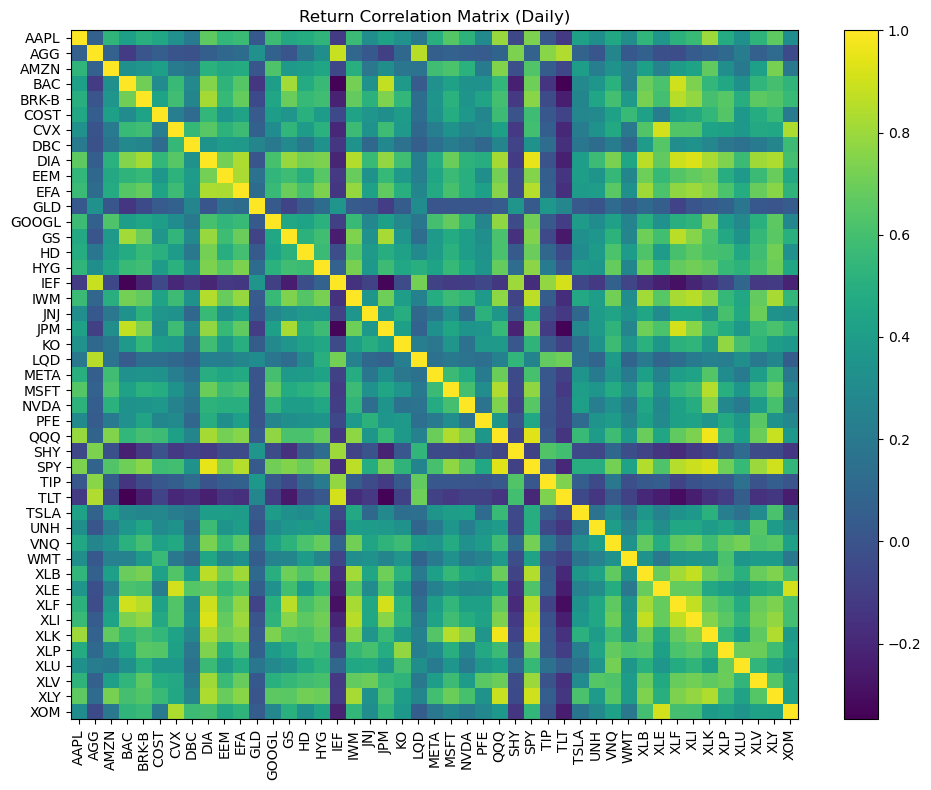

In [9]:
corr = correlation_matrix(rets)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.title("Return Correlation Matrix (Daily)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()


In [10]:
# Save prices and returns
prices_filt.to_parquet(RAW_PRICES_PARQUET)
rets.to_parquet(PROCESSED_RETURNS_PARQUET)

print("Saved:", RAW_PRICES_PARQUET)
print("Saved:", PROCESSED_RETURNS_PARQUET)


Saved: data/raw/prices.parquet
Saved: data/processed/returns.parquet
